In [1]:
import numpy as np
import pandas as pd
import random
import torch
from matplotlib import pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import plotly
import plotly.graph_objs as go

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [4]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

In [5]:
import collections

In [6]:
!pip install yfinance
clear_output()
import yfinance as yf

In [7]:
df = yf.download(tickers='TSLA')
df = df[-1000:]
df = df.reset_index(drop=True)
print(df.head())

[*********************100%***********************]  1 of 1 completed

Price    Adj Close       Close        High         Low        Open     Volume
Ticker        TSLA        TSLA        TSLA        TSLA        TSLA       TSLA
0       162.213333  162.213333  165.333328  147.833328  149.449997  234132000
1       166.423340  166.423340  169.536667  162.523331  164.000000  187425900
2       163.203339  163.203339  167.500000  163.020004  165.996674   98735700
3       173.949997  173.949997  175.333328  167.263336  167.833328  150780900
4       185.126663  185.126663  186.663330  175.399994  180.133331  160945500


In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    y = df['Close'][:],
    line =  dict(shape =  'spline' ),
    name = 'Курс акции TSLA'
            ))
fig.show()

In [9]:
df['Close']

Ticker,TSLA
0,162.213333
1,166.423340
2,163.203339
3,173.949997
4,185.126663
...,...
995,242.839996
996,251.440002
997,288.529999
998,296.910004


In [10]:
class Environment:
    '''
        Рабочая среда робота, внутри которого будет
        происходить дальнейшее обучение
    '''
    def __init__(self, train_data, test_data, normalize = True, noise = True):
        self.train_length = train_data.shape[0]
        self.test_length = test_data.shape[0]
        self.data = np.concatenate([train_data.flatten(), test_data.flatten()])


        if noise:
            # Подаем шум для данных от 0.1 до 1
            self.data += np.random.normal(0, 0.1, size = self.data.shape)
        if normalize:
            # Нормализация после данных после шума
            self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def get_state(self, time, lookback, diff = True):
        """
        Возвращаем производные отдельного окна в нашей выборке
        и убираем нули в начале
        """
        window = self.data[time-lookback:time]
        if diff: window = np.diff(window, prepend = window.flatten()[0])
        return window

    def get_reward(self, action, action_time, reward_time, coef = 100):
        """
        Основная логика получения награды
        0 => long 1 => hold 2 => short
        """
        if action == 0:
            action = -1
        elif action == 1:
            action = 1

        # print(23, self.data)
        # Вытаскиваем текущую цену
        price_now = self.data[action_time]
        # Вытаскиваем следующую цену
        price_reward = self.data[reward_time]
        # Получаем разницу в проценте
        price_diff = (price_reward - price_now)
        # Прибавляем к портфелю следующее число:
        # Дельта изменения валюты * покупку/продажу/холд * коэф. закупки
        reward = price_diff * action * coef
        # print(12121, reward)
        return reward

We don't want to study trading, we need to develop intuition to predict the price. Thus, a small simple NN is needed.

In [11]:
# Обратите внимание на то, что в RL часто используются совсем простые нейронные сети
class Net(nn.Module):
    """Строим простую модель нейронки"""
    def __init__(self, state_shape, action_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_shape, 10)
        self.fc2 = nn.Linear(10, action_shape)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = F.tanh(self.drop(self.fc1(x)))
        x = self.fc2(x)
        return x

In [12]:
class BuyHoldSellAgent:
    '''
        Агент для покупки продажи
    '''
    def __init__(self, state_shape = 10, action_shape = 2, experience_size = 100):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.experience_size = experience_size
        self.experience = collections.deque(maxlen=self.experience_size)

        # Создадим экземпляр модели
        self.model = Net(state_shape, action_shape)

        # Создадим функцию ошибки
        self.criterion = nn.HuberLoss()
        # Добавим оптимизатор
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.0002)

    def save_experience(self, current_state, action, reward, next_state):
        """Метод для сохранения предудыщих данных эксперимента"""
        self.experience.append({
            'state_i': current_state,
            'action_i': action,
            'reward_i': reward,
            'state_i_1': next_state
        })

    def replay_experience(self, gamma, sample_size):
        """Метод для оптимизации данных тренировки"""
        # Создаем фиксированную выборку из добавленных событий
        indices_sampled = np.random.choice(
            len(self.experience),
            sample_size,
            replace=False
        )
        # Проходимся только по тем элементам, которые были добавлены в выборку

        current_states = []
        actions = []
        rewards = []
        next_states = []
        for i in indices_sampled:
            state_i, action_i, reward_i, state_i_1 = self.experience[i]['state_i'], self.experience[i]['action_i'], self.experience[i]['reward_i'], self.experience[i]['state_i_1']
            current_states.append(state_i)
            actions.append(action_i)
            rewards.append(reward_i)
            next_states.append(state_i_1)

        current_states = np.array(current_states).squeeze()
        next_states = np.array(next_states).squeeze()

        # Получаем прогноз по следующему состоянию
        next_q_values = self.model(torch.from_numpy(next_states).float()).detach().numpy()

        # Получаем прогноз по текущему состоянию
        current_q_values = self.model(torch.from_numpy(current_states).float()).detach().numpy()
        # Уравнение Бэллмена
        # Суть в том, что мы берем максимально возможную награду
        # из действия из будущего шага (q_value_i_1) , умножаем ее на гамму
        # (коэф. значимости будущих наград), прибавляем к текущей награде
        for i in range(len(indices_sampled)):
            # и заносим в Q таблицу для обучения
            current_q_values[i, actions[i]] = rewards[i] + gamma * next_q_values[i, :].max()

        outputs = self.model(torch.from_numpy(np.expand_dims(current_states.reshape(-1, WINDOW_SHAPE), 0)).float())[0]
        loss = self.criterion(outputs, torch.Tensor(current_q_values))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_value_action_value(self, state):
        """Метод для прогноза сигнала"""
        state = np.expand_dims(state, axis = 0)
        pred = self.model(torch.from_numpy(state).float())
        return pred.flatten()

In [13]:
# Количество эпох обучения
epochs = 100
# Коэф. значимости награды на шаг вперед
gamma = 0.9
# Количество эпох обучения
epsilon = 0.95

In [14]:
# Размер датасета
DATASET_LENGTH = len(df['Close'])
# Размер окна из которого будут браться предыдущие данные
WINDOW_SHAPE = 40
# Шаг предыдущих данных
REWARD_TIME = 1
# Число доступных действий
ACTIONS_SHAPE = 2
# Размер выборки
SAMPLE_SIZE = 100


In [15]:
action_to_backtest_action = {
    1: 1,  # покупаем
    0: -1,  # продаем
}

In [16]:
train_dataset = np.array(df['Close'][:-50])
test_dataset = np.array(df['Close'][-50:])

In [17]:
# Прописываем новую среду и передаем данные о закрытии цены
environment = Environment(train_dataset, test_dataset, normalize = False, noise = False)
agent = BuyHoldSellAgent(WINDOW_SHAPE, ACTIONS_SHAPE)

In [18]:
set_random_seed(42)


for i in range(epochs):

    learning_progress = []
    for j in range(WINDOW_SHAPE, environment.train_length - REWARD_TIME, REWARD_TIME):
        print(f"{i} / {epochs} : {j} {DATASET_LENGTH - REWARD_TIME}", end='\r')

        # 1. Получаем текущее состояние. Производные в отдельном интервале
        # Текущий Y на графике и предыдущие WINDOW_SHAPE шагов
        state_j = environment.get_state(j, WINDOW_SHAPE)
        # Получаем предсказание по данному состоянию через модель
        q_value_j = agent.get_value_action_value(state_j)

        # 2. Выбираем действие для текущего состояния
        # В зависимости от длины эпсилона, выбираем случайное действие
        # или реальные по предсказаниям
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = np.argmax(q_value_j.detach().numpy())

        # 3. Получаем награду за выбранное действие
        reward_value_j = environment.get_reward(action, j, j + REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. Получаем будущее состояние. Производные в будущем интервале
        # Текущий Y + 1 на графике и предыдущие WINDOW_SHAPE шагов
        state_j_1 = environment.get_state(j + 1, WINDOW_SHAPE)

        # 5. Сохраняем все полученные данные в агента
        agent.save_experience(state_j, action, reward_value_j, state_j_1)

        # 6. Как только число ранее полученных сэмплов перевалило
        # за необходимое, начинаем тренировать сеть
        if j > SAMPLE_SIZE * 2:
            agent.replay_experience(gamma, SAMPLE_SIZE)

    # С каждым шагом уменьшаем эпсилон, чтобы бот начинал действовать
    # по собственным прогнозам и переставал изучать среду
    epsilon = 1.0 / (i+1)

    print('Epoch', i, '...', np.mean(learning_progress))
    learning_progress = []

Epoch 0 ... 28.188870370191317
Epoch 1 ... -51.632213697443966
Epoch 2 ... 72.60108670779188
Epoch 3 ... 88.97799753119843
Epoch 4 ... 85.31023283602774
Epoch 5 ... 104.98899957134385
Epoch 6 ... 138.34360624172768
Epoch 7 ... 96.38466242254108
Epoch 8 ... 102.96044008697744
Epoch 9 ... 170.3912951109564
Epoch 10 ... 147.4151275601193
Epoch 11 ... 136.2519485591137
Epoch 12 ... 131.2024677809578
Epoch 13 ... 166.23507962368504
Epoch 14 ... 165.2801849398807
Epoch 15 ... 146.8438143252802
Epoch 16 ... 170.61498660852413
Epoch 17 ... 199.13127634784962
Epoch 18 ... 192.01138100870634
Epoch 19 ... 159.44084612318653
Epoch 20 ... 184.87901509267138
Epoch 21 ... 186.2724782610097
Epoch 22 ... 184.14779679872285
Epoch 23 ... 211.51635030446403
Epoch 24 ... 184.52991447826423
Epoch 25 ... 206.03778868487436
Epoch 26 ... 193.6673960669993
Epoch 27 ... 233.91679484720933
Epoch 28 ... 194.02459273637325
Epoch 29 ... 196.01285659571818
Epoch 30 ... 180.7646093588851
Epoch 31 ... 218.7506513102482

In [19]:
actions = []

for j in range(WINDOW_SHAPE, len(df['Close']), REWARD_TIME):
    # 1. Получаем производные в отдельном интервале
    # Текущая цена и предыдущие WINDOW_SHAPE шагов
    state_j = environment.get_state(j, WINDOW_SHAPE)

    # Получаем предикт бота по данным
    q_value_j = agent.get_value_action_value(state_j)
    # Определяем сигнал и записываем в события
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

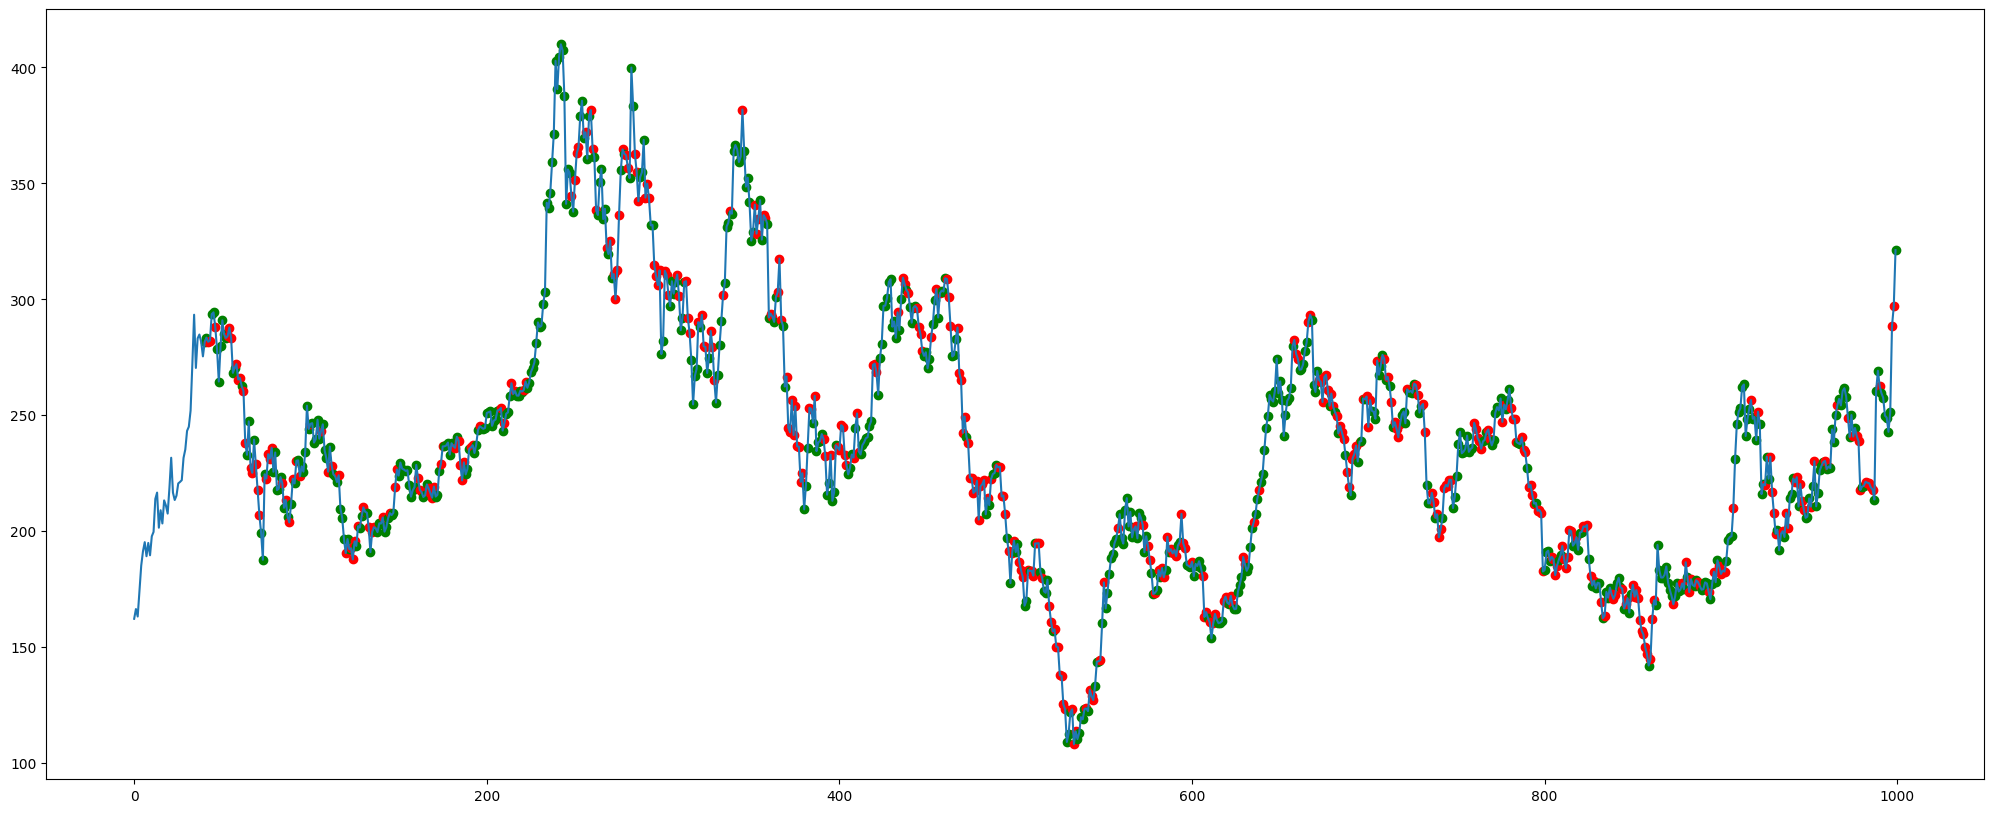

In [20]:
plt.figure(figsize = (25, 10))
plt.plot(environment.data)
for e, a in enumerate(actions):
    print(f"{e} {a}", end='\r')
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment.data[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment.data[e], color = 'red')

plt.show()

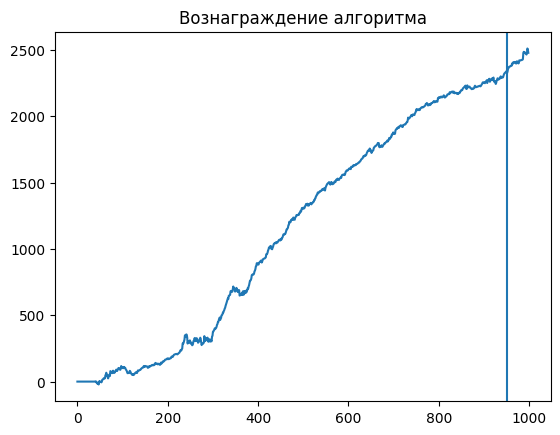

In [22]:
 # Составляем график доходов. Сделаем фрейм формата Цена/Сигнал
backtest = pd.DataFrame({
    'price': environment.data.flatten(),
    # и добавить дополнительные 5 элементов в начало с сигналом 0
    'signal': [0] * WINDOW_SHAPE + actions
})
# Получаем производные цен и делаем сдвиг
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# Суммируем доходы и выводим график
(backtest['price_diff'] * backtest['signal']).cumsum().plot()
plt.title('Вознаграждение алгоритма')

plt.axvline(x=950)
plt.show()